# COMP9418 - Assignment 1 - Bayesian Networks as Classifiers

## UNSW Sydney, October 2020

- Minrui Lu z5277884
- Yangqi Zhang z5235062

## Instructions

**Submission deadline:** Sunday, 18th October 2020, at 18:00:00.

**Late Submission Policy:** The penalty is set at 20% per late day. This is ceiling penalty, so if a group is marked 60/100 and they submitted two days late, they still get 60/100.

**Form of Submission:** This is a group assignment. Each group can have up to **two** students. **Only one member of the group should submit the assignment**.

You can reuse any piece of source code developed in the tutorials.

Submit your files using give. On a CSE Linux machine, type the following on the command-line:

``$ give cs9418 ass1 solution.zip``

Alternative, you can submit your solution via the [WebCMS](https://webcms3.cse.unsw.edu.au/COMP9418/20T3).

## Technical prerequisites

These are the libraries your are allowed to use. No other libraries will be accepted.

In [1]:
# Make division default to floating-point, saving confusion
from __future__ import division
from __future__ import print_function

# Allowed libraries
import numpy as np
import pandas as pd
import scipy as sp
import heapq as pq
import matplotlib as mp
import math
from itertools import product, combinations
from collections import OrderedDict as odict
from graphviz import Digraph
from tabulate import tabulate

# Supplemental libraries
import copy
import warnings
warnings.filterwarnings('ignore')
import time

## Initial task - Initialise graph

Create a graph ``G`` that represents the following network by filling in the edge lists.
![Bayes Net](BayesNet.png)


In [2]:
G = {
    "BreastDensity" : ["Mass"],
    "Location" : ["BC"],
    "Age" : ["BC"],
    "BC" : ["Mass", "AD", "Metastasis", "MC", "SkinRetract","NippleDischarge"],
    "Mass" : ["Size",  "Shape", "Margin" ],
    "AD" : ["FibrTissueDev"],
    "Metastasis" : [ "LymphNodes"],
    "MC" : [],
    "Size" : [],
    "Shape" : [],
    "FibrTissueDev" : [ "SkinRetract" , "NippleDischarge","Spiculation" ],
    "LymphNodes" : [],
    "SkinRetract" : [],
    "NippleDischarge" : [],
    "Spiculation" : ["Margin" ],
    "Margin" : [],
}

## [20 Marks] Task 1 - Efficient d-separation test

Implement the efficient version of the d-separation algorithm in a function ``d_separation(G, X, Z, Y)`` that return a boolean: true if **X** is d-separated from **Y** given **Z** in the graph $G$ and false otherwise.

* **X**,**Y** and **Z** are python sets, each containing a set of variable names. 
* Variable names may be strings or integers, and can be assumed to be nodes of the graph $G$. 
* $G$ is a graph as defined in tutorial 1.

In [3]:
import copy 

def isleaf_node(G,node):
    return not G[node] 

# delete the leaf node and its edges from the G, return a new Graph
def remove_leaf(G1,leaf_node):
    G_new = copy.deepcopy(G1)
    del G_new[leaf_node]
    for key, value in  G_new.items(): 
        if leaf_node in value:
            G_new[key].remove(leaf_node)
    return G_new
    
def repeat_del(G1,node_list): 
    count = 1 
    list_update = node_list.copy()
    while count > 0:
        count = 0
        for node in node_list: 
            if isleaf_node(G1,node):
                #remove the nodes and update the graph 
                G1= copy.deepcopy(remove_leaf(G1,node))
                list_update.remove(node)
                count = count + 1 
        node_list = list_update.copy()
    return (G1)

    
def dfs_r(G, v, colour):
    """
    argument 
    `G`, an adjacency list representation of a graph
    `v`, next vertex to be visited
    `colour`, dictionary with the colour of each node
    """
    # Visited vertices are coloured 'grey'
    colour[v] = 'grey'
    # Let's visit all outgoing edges from v
    for w in G[v]:
        # To avoid loops, we vist check if the next vertex hasn't been visited yet
        if colour[w] == 'white':
            dfs_r(G, w, colour)
    # When we finish the for loop, we know we have visited all nodes from v. It is time to turn it 'black'
    colour[v] = 'black' 
    return None
  


def d_separation(G1, X, Z, Y): 
    """ 
    Arguments: 
    `G`, an adjacency list representation of a graph 
    `X`, a set of variables name 
    `Y`, a set of variables name 
    `Z`, a set of a set of variables name 
    
    Returns 
    a boolean: true if X is d-separated from Y given Z in the graph  𝐺  and false otherwise.
    
    """
    if bool(X.intersection(Y).intersection(Z)):
        raise Exception("X, Y, Z are not disjoint") 
    
    combine_set = X.union(Y).union(Z)
    node_set = set(G1.keys())
    remain_nodes = set(node_set  - combine_set)
    
    G_final = copy.deepcopy(repeat_del(G1,remain_nodes)) 
    
    for var in Z: 
        G_final[var] = [] 
    
    for key,values in G_final.items():
        if bool(values):
            for n in values: 
                G_final[n].append(key) 

    colour = {node: 'white' for node in G_final.keys()}
    #check connectivity 
    separate = True 
    for nodex in X:
        dfs_r(G_final,nodex,colour) 
        Y_color = [colour[node] for node in Y]
        if 'black' in Y_color:
            separate = False
    return(separate)
        

In [4]:
############
## TEST CODE

def test(statement):
    if statement:
        print("Passed test case")
    else:
        print("Failed test case")
        
test(d_separation(G, set(['Age']), set(['BC']), set(['AD'])))
test(not d_separation(G, set(['Spiculation','LymphNodes']), set(['MC', 'Size']), set(['Age'])))

Passed test case
Passed test case


## [10 Marks] Task 2 - Estimate Bayesian Network parameters from data

Implement a function ``learn_outcome_space(data)`` that learns the outcome space (the valid values for each variable) from the pandas dataframe ``data`` and returns a dictionary ``outcomeSpace`` with these values.

Implement a function ``learn_bayes_net(G, data, outcomeSpace)`` that learns the parameters of the Bayesian Network $G$. This function should return a dictionary ``prob_tables`` with the all conditional probability tables (one for each node).

- ``G`` is a directed acyclic graph. For this part of the assignment, $G$ should be declared according to the breast cancer Bayesian network presented in the diagram in the assignment specification.
- ``data`` is a dataframe created from a csv file containing the relevant data. 
- ``outcomeSpace`` is defined in tutorials.
- ``prob_tables`` is a dict from each variable name (node) to a "factor". Factors are defined in tutorial 2. 

In [5]:
## Develop your code for learn_outcome_space(data) in one or more cells here

In [6]:
def learn_outcome_space(data):
    outcomeSpace = {}
    for attr in data.columns:
        outcomeSpace[attr] = tuple(data[attr].unique())
    return(outcomeSpace)

In [7]:
############
## TEST CODE

with open('bc.csv') as file:
    data = pd.read_csv(file)

outcomeSpace = learn_outcome_space(data)

outcomes = outcomeSpace['BreastDensity']
answer = ('high', 'medium', 'low')
test(len(outcomes) == len(answer) and set(outcomes) == set(answer))

Passed test case


In [8]:
## Develop your code for learn_bayes_net(G, data, outcomeSpace) in one or more cells here

In [9]:
# Auxilliary functions
def printFactor(f):
    """
    argument 
    `f`, a factor to print on screen
    """
    # Create a empty list that we will fill in with the probability table entries
    table = list()
    
    # Iterate over all keys and probability values in the table
    for key, item in f['table'].items():
        k = list(key)
        k.append(item)
        table.append(k)
    dom = list(f['dom'])
    dom.append('Pr')
    print(tabulate(table,headers=dom,tablefmt='fancy_grid'))
    
def prob(factor, *entry):
    """
    argument 
    `factor`, a dictionary of domain and probability values,
    `entry`, a list of values, one for each variable in the same order as specified in the factor domain.
    
    Returns p(entry)
    """
    return factor['table'][entry]  

In [10]:
def allEqualThisIndex(dict_of_arrays,**fixed_vars):
    first_array = dict_of_arrays[list(dict_of_arrays.keys())[0]]
    index = np.ones_like(first_array,dtype=np.bool_)
    for var_name,var_val in fixed_vars.items():
        index = index & (np.asarray(dict_of_arrays[var_name])==var_val)
    return (index)

def estProbTable(data,var_name,parent_names,outcomeSpace,alpha=1):
    var_outcomes = outcomeSpace[var_name]
    parent_outcomes = [outcomeSpace[var] for var in parent_names]
    all_parent_combinations = product(*parent_outcomes)
    prob_table = odict()
    
    for i,parent_combination in enumerate(all_parent_combinations):
        parent_vars = dict(zip(parent_names,parent_combination))
        parent_index = allEqualThisIndex(data,**parent_vars)
        for var_outcome in var_outcomes:
            var_index = (np.asarray(data[var_name])==var_outcome)
            new_dom = tuple(list(parent_combination)+[var_outcome])

            # Additive smoothing is applied here
            
            N = parent_index.sum()
            c = (var_index & parent_index).sum()
            X_cardinality = len(var_outcomes)
            prob_table[new_dom] = (c+alpha)/(N+alpha*X_cardinality)
            
    return({'dom':tuple(list(parent_names)+[var_name]),'table':prob_table})

def transposeGraph(G):
    GT = dict((v,[]) for v in G)
    for v in G:
        for w in G[v]:
            GT[w].append(v)
    return (GT)

In [11]:
def learn_bayes_net(G,data,outcomeSpace):
    bayes_net = odict()
    GT = transposeGraph(G)
    for child, parents in GT.items():
        bayes_net[child] = estProbTable(data,child,parents,outcomeSpace)
    return(bayes_net)

In [12]:
############
## TEST CODE
prob_tables = learn_bayes_net(G, data, outcomeSpace)
test(abs(prob_tables['Age']['table'][('35-49',)] - 0.2476) < 0.001)

Passed test case


## [20 Marks] Task 3 - Bayesian Network Classification

Design a new function ``assess_bayes_net(G, prob_tables, data, outcomeSpace, class_var)`` that uses the test cases in ``data`` to assess the performance of the Bayesian network defined by ``G`` and ``prob_tables``. Implement the efficient classification procedure discussed in the lectures. Such a function should return the classifier accuracy. 
 * ``class_var`` is the name of the variable you are predicting, using all other variables.
 * ``outcomeSpace`` was created in task 2
 
Remember to remove the variables ``metastasis`` and ``lymphnodes`` from the dataset before assessing the accuracy.

Return just the accuracy:

``acc = assess_bayes_net(G, prob_tables, data, outcomeSpace, class_var)``

In [13]:
## Develop your code for assess_bayes_net(G, prob_tables, data, outcomeSpace, class_var) in one or more cells here
def join(f1, f2, outcomeSpace):
    """
    argument 
    `f1`, first factor to be joined.
    `f2`, second factor to be joined.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns a new factor with a join of f1 and f2
    """
    common_vars = list(f1['dom']) + list(set(f2['dom']) - set(f1['dom']))
    table = list()
    for entries in product(*[outcomeSpace[node] for node in common_vars]):
        entryDict = dict(zip(common_vars, entries))
        f1_entry = (entryDict[var] for var in f1['dom'])
        f2_entry = (entryDict[var] for var in f2['dom'])
        p1 = prob(f1, *f1_entry)          
        p2 = prob(f2, *f2_entry)           
        table.append((entries, p1 * p2))
    return {'dom': tuple(common_vars), 'table': odict(table)}

def p_joint(outcomeSpace, cond_tables):
    """
    argument 
    `outcomeSpace`, dictionary with domain of each variable
    `cond_tables`, conditional probability distributions estimated from data
    
    Returns a new factor with full joint distribution
    """       
    var_list = list(outcomeSpace.keys())
    p = join(cond_tables[var_list[0]], cond_tables[var_list[1]], outcomeSpace)

    for var in var_list[2:]:
        p = join(p,cond_tables[var_list[var]],outcomeSpace)
    return p




In [14]:
# Return a markov blanket of a given variable in the graph
def markov_blanket(G,var):
    blanket_list = []
    blanket_list = blanket_list + G[var] #include the children
    children_list = blanket_list 
    GT = transposeGraph(G)
    blanket_list = blanket_list + GT[var] #include the parents     
    for node in children_list:
        blanket_list = blanket_list + GT[node] #include spouse 
    
    blanket_list = list(set(blanket_list))
    blanket_list = [i for i in blanket_list if i != var]
    return blanket_list

# Join each variable's markov blanket in the outcomeSpace together
def p_joint_blanket(my_blanket, outcomeSpace, cond_tables):
    var_list = my_blanket
    p = join(cond_tables[var_list[0]], cond_tables[var_list[1]], outcomeSpace)
    for var in var_list[2:]:
        p = join(p,cond_tables[var], outcomeSpace)
    return p


In [15]:
def evidence(var, e, outcomeSpace):
    """
    argument 
    `var`, a valid variable identifier.
    `e`, the observed value for var.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns dictionary with a copy of outcomeSpace with var = e
    """    
    newOutcomeSpace = outcomeSpace.copy()      
    newOutcomeSpace[var] = (e,)               
    return newOutcomeSpace

def marginalize(f, var, outcomeSpace):
    """
    argument 
    `f`, factor to be marginalized.
    `var`, variable to be summed out.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns a new factor f' with dom(f') = dom(f) - {var}
    """    
    new_dom = list(f['dom'])
    
    new_dom.remove(var)           
    table = list()                 
    for entries in product(*[outcomeSpace[node] for node in new_dom]):
        s = 0;                     
        for val in outcomeSpace[var]:
            entriesList = list(entries)
            entriesList.insert(f['dom'].index(var), val)
            p = prob(f, *tuple(entriesList))     
            s = s + p                           
        
        table.append((entries, s))
    return {'dom': tuple(new_dom), 'table': odict(table)}


def normalize(f):
    """
    argument 
    `f`, factor to be normalized.
    
    Returns a new factor f' as a copy of f with entries that sum up to 1
    """ 
    table = list()
    sum = 0
    for k, p in f['table'].items():
        sum = sum + p
    for k, p in f['table'].items():
        table.append((k, p/sum))
    return {'dom': f['dom'], 'table': odict(table)}


def query(p, outcomeSpace, q_vars, **q_evi):
    """
    argument 
    `p`, probability table to query.
    `outcomeSpace`, dictionary will variable domains
    `q_vars`, list of variables in query head
    `q_evi`, dictionary of evidence in the form of variables names and values
    
    Returns a new factor NORMALIZED factor will all hidden variables eliminated as evidence set as in q_evi
    """     
    pm = p.copy()
    outSpace = outcomeSpace.copy()

    for var_evi, e in q_evi.items():
        outSpace = evidence(var_evi, e, outSpace)
    for var in outSpace:
        if not var in q_vars:
            pm = marginalize(pm, var, outSpace)
    return normalize(pm)

In [16]:
# Return the accuracy of a Bayes network given a data
def assess_bayes_net(G, prob_tables, data, outcomeSpace, class_var): 
    var_blanket = markov_blanket(G,class_var)
    var_blanket.append(class_var)
    var_remove = ['Metastasis', 'LymphNodes']
    # now we get the variables that needs for inference class_var
    var_list = [i for i in var_blanket if i not in var_remove]  
    p_table =  p_joint_blanket(var_list, outcomeSpace, prob_tables) 
    q_var = class_var
    evidence_list = [var for var in var_list if var!=class_var]
    data_update = data[evidence_list]
    data_dict = data_update.to_dict(orient='records')
    new_outcomeSpace = { var: outcomeSpace[var] for var in var_list}
    match_count = 0
    for i in range(len(data_dict)):
        q_table = query(p_table, new_outcomeSpace, q_var, **data_dict[i])
        pred = max(q_table['table'],key=q_table['table'].get)[0]
        if (pred == data.iloc[i][q_var]):
            match_count +=1
    return (match_count/data.shape[0])

In [17]:
############
## TEST CODE
class_var = "BC"
acc = assess_bayes_net(G, prob_tables, data, outcomeSpace, class_var)

In [18]:
acc

0.8423

Develop a function ``cv_bayes_net(G, data, class_var)`` that uses ``learn_outcome_space``, ``learn_bayes_net``and ``assess_bayes_net`` to learn and assess a Bayesian network in a dataset using 10-fold cross-validation. Compute and report the average accuracy over the ten cross-validation runs as well as the standard deviation, e.g.

``acc, stddev = cv_bayes_net(G, data, class_var)``

In [19]:
## Develop your code for cv_bayes_net(G, data, class_var) in one or more cells here

In [20]:
# The cross validation is 10 fold here
def cv_bayes_net(G,data,class_var):
    outcomeSpace = learn_outcome_space(data)
    fold_len = int(data.shape[0]/10)
    acc_list = []
    for i in range(10):
        training_index = list(range(0,i*fold_len)) + list(range((i+1)*fold_len,data.shape[0]))
        test_index = list(range(i*fold_len,(i+1)*fold_len))
        training_data = data.iloc[training_index]
        test_data = data.iloc[test_index]
        prob_tables = learn_bayes_net(G,training_data,outcomeSpace)
        acc_list.append(assess_bayes_net(G,prob_tables,test_data,outcomeSpace,class_var))
    return (np.mean(acc_list),np.std(acc_list))

In [21]:
############
## TEST CODE
begin = time.time()
acc, stddev = cv_bayes_net(G, data, 'BC')
end = time.time()
print("The accuracy is {0:.4f}, and the standard deviation is {1:.2f}".format(acc,stddev))
print("The time consumption is {0:.2f} seconds".format(end-begin))

The accuracy is 0.8412, and the standard deviation is 0.01
The time consumption is 6.76 seconds


## [10 Marks] Task 4 - Naïve Bayes Classification

Design a new function ``assess_naive_bayes(G, prob_tables, data, outcomeSpace, class_var)`` to classify and assess the test cases in a dataset ``data`` according to the Naïve Bayes classifier. To classify each example, use the log probability trick discussed in the lectures. This function should return the accuracy of the classifier in ``data``.

In [22]:
## Develop your code for assess_naive_bayes(G, prob_tables, data, outcomeSpace, class_var) in one or more cells here

# Return a Naive Bayes graph, in which there is only one parent, and other nodes are all its child
def learn_naive_bayes_structure(outcomeSpace, class_var):
    """Return the naive-bayes graph structure (a dict) according to above info"""
    G_nb = {}
    node_list = list(outcomeSpace.keys())
    node_list.remove(class_var)
    G_nb[class_var] = node_list
    for nodes in node_list:
        G_nb[nodes] = []
    return G_nb

def additive_smoothing(prop_tables,data,alpha=1):
    N = data.shape[0]
    tables = copy.deepcopy(prop_tables)
    for node , table_dict in tables.items():
        X_cardinality = len(table_dict['table'].values())
        if (0 in table_dict['table'].values()): # addtive smoothing required
            for nameSpace, prob in table_dict['table'].items():
                count_X_eq_x = int(round(prob * N,0))
                table_dict['table'][nameSpace] = (count_X_eq_x+alpha)/(N+alpha*X_cardinality)
    return (tables)

#Return the log likelihood for each evidence variable
def single_var_query( e, node_table):
    # using log to avoid probability diminishing
    prob_with_evi = {key[0]: np.log(value) for key,value in node_table['table'].items() if key[1] == e}    
    return prob_with_evi

# Given a line of data, return the class prediction
def predict(x, y_space, table, prior):
    # initialize the prediction dictionary by the prior probabilities
    pre_dict = {i:  np.log(prior[i]) for i in y_space if prior[i]!=0}
    for i in range(len(x)):
        var_prob = single_var_query(x[i], table[x.index[i]])
        for key in pre_dict.keys():
            pre_dict[key] = pre_dict[key] +  var_prob[key]    
    yhat = max(pre_dict, key=pre_dict.get)   
    return yhat 

# Return the accuracy of a Naive Bayes network in the test data
def assess_naive_bayes(G_naive, naive_tables, data, outcomeSpace, class_var):
    naive_tables = additive_smoothing(naive_tables,data)   
    node_list = list(outcomeSpace.keys())
    var_remove = ['Metastasis', 'LymphNodes']
    var_list = [i for i in node_list if i not in var_remove] #now we get all the variables    
    evidence_list = [var for var in var_list if var!=class_var]
    data_update = data[evidence_list]
    prior_prob = data[class_var].value_counts(normalize = True)   
    y_hat_series = data_update.apply(predict, y_space = outcomeSpace[class_var], table = naive_tables, prior = prior_prob, axis = 1)
    correct_predict = np.sum(data[class_var] == y_hat_series)
    acc = correct_predict/len( y_hat_series)
    return acc

In [23]:
############
## TEST CODE
G_naive = learn_naive_bayes_structure(outcomeSpace,class_var)
naive_tables = learn_bayes_net(G_naive, data, outcomeSpace)
acc = assess_naive_bayes(G_naive, naive_tables, data, outcomeSpace, 'BC')
acc 

0.7926

Develop a new function ``cv_naive_bayes(data, class_var)`` that uses ``assess_naive_bayes`` to assess the performance of the Naïve Bayes classifier in a dataset ``data``. To develop this code, perform the following steps:

1. Use 10-fold cross-validation to split the data into training and test sets.

2. Implement a function ``learn_naive_bayes_structure(outcomeSpace, class_var)`` to create and return a Naïve Bayes graph structure from ``outcomeSpace`` and ``class_var``. 

3. Use ``learn_bayes_net(G, data, outcomeSpace)`` to learn the Naïve Bayes parameters from a training set ``data``. 

4. Use ``assess_naive_bayes(G, prob_tables, data, outcomeSpace, class_var)`` to compute the accuracy of the Naïve Bayes classifier in a test set ``data``. Remember to remove the variables ``metastasis`` and ``lymphnodes`` from the dataset before assessing the accuracy.

Do 10-fold cross-validation, same as above, and return ``acc`` and ``stddev``.

In [24]:
## Develop your code for cv_naive_bayes(data, class_var) in one or more cells here

In [25]:
def cv_naive_bayes(data,class_var):
    outcomeSpace = learn_outcome_space(data)
    fold_len = int(data.shape[0]/10)
    acc_list = []
    G_naive = learn_naive_bayes_structure(outcomeSpace,class_var)
    for i in range(10):
        training_index = list(range(0,i*fold_len)) + list(range((i+1)*fold_len,data.shape[0]))
        test_index = list(range(i*fold_len,(i+1)*fold_len))
        training_data = data.iloc[training_index]
        test_data = data.iloc[test_index]
        naive_tables = learn_bayes_net(G_naive, training_data, outcomeSpace)
        acc_list.append(assess_naive_bayes(G_naive, naive_tables, test_data, outcomeSpace,class_var))
    return (np.mean(acc_list),np.std(acc_list))

In [26]:
begin = time.time()
acc, stdev = cv_naive_bayes(data,class_var)
end = time.time()
print("The time consumption is {0:.2f} seconds".format(end-begin))
print("The accuracy is {0:.4f}, and the standard deviation is {1:.2f}".format(acc,stddev))

The time consumption is 9.26 seconds
The accuracy is 0.7919, and the standard deviation is 0.01


## [20 Marks] Task 5 - Tree-augmented Naïve Bayes Classification

Similarly to the previous task, implement a Tree-augmented Naïve Bayes (TAN) classifier and evaluate your implementation in the breast cancer dataset. Design a function ``learn_tan_structure(data, outcomeSpace, class_var)`` to learn the TAN structure (graph) from the ``data`` and returns such a structure.

# Note by Yangqi : The following functions are used to enable more efficient (maybe) computation for mutual information 

To calculate conditional mutual info: 
https://en.wikipedia.org/wiki/Conditional_mutual_information#Some_identities


$I(X;Y|Z) = H(X|Z) + H(Y|Z) - H(X,Y|Z)$

$\mathrm{H}(Y \mid X)=-\sum_{x \in \mathcal{X}, y \in \mathcal{Y}} p(x, y) \log \frac{p(x, y)}{p(x)}$

using the Entropy identity: we can calculate it easily. To calculate entropy, we need to know the distribution for each jotint var, 
df.value_counts will be usful 
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.value_counts.html

Then we simply calculate entropy and workout the conditional mutual info. 

https://stackoverflow.com/questions/49685591/how-to-find-the-entropy-of-each-column-of-data-set-by-python

After that, Bayesian graph can be quickly obtain by max span tree 


In [27]:
import math

# Calculate the conditional entropy
def cond_entro(var_list,class_var,data):
    probs_class_var = dict(data[class_var].value_counts(normalize=True,sort=False))
    var_list.append(class_var)
    probs_join_var = dict(data.groupby(var_list).size())
    join_sum = sum(probs_join_var.values())
    probs_join_var = {key:value/join_sum for key,value in probs_join_var.items()}
    entropy = 0 
    for key,value in probs_join_var.items():
        entropy -= value * np.log(value/probs_class_var[key[-1]])
    return entropy

In [28]:
# Calculate the mutual information between var1 and var2 given class_var by using conditional entropy
def MI(var1,var2,class_var,data):
    mutual_info = cond_entro([var1],class_var,data) + \
                  cond_entro([var2],class_var,data) - \
                  cond_entro([var1,var2],class_var,data)
    return(mutual_info)

In [29]:
# The following two functions are for checking whehter a graph is cyclic
def isCyclicUtil(v,visited,parent,MST):
    visited[v] = True 
    for node in MST[v]:
        if (visited[node]==False):
            if(isCyclicUtil(node,visited,v,MST)):
                return True
        elif(parent!=node):
            return True
    return False

def isCyclic(MST,node_list):
    visited = {node:False for node in node_list}
    
    for node in node_list:
        if (visited[node]==False):
            if(isCyclicUtil(node,visited,None,MST)==True):
                return True
    return False

# Return a maximum spanning tree for given edges
def max_spanning_tree(input_edges,outcomeSpace,class_var):
    node_list = list(outcomeSpace.keys())
    node_list.remove("Metastasis")
    node_list.remove("LymphNodes")
    MST = {node:[] for node in node_list}
    node_list.remove(class_var)
    edge_count = 0
    edges = copy.deepcopy(input_edges)
    edges.sort(reverse=True,key=lambda x:x[1])
    
    while(len(edges)>0):
        edge = edges.pop(0)[0]
        MST[edge[0]].append(edge[1])
        MST[edge[1]].append(edge[0])
        edge_count +=1
        
        if (isCyclic(MST,node_list)):
            MST[edge[0]].remove(edge[1])
            MST[edge[1]].remove(edge[0])
            edge_count -=1
        
        if (edge_count == len(node_list)-1):
            return (MST)

In [30]:
# Generate a Maximum Spanning Tree with directed edges
def generate_directed_MST(G_tan,MST,node,node_count):
    children = MST[node]
    for child in children:
        MST[child].remove(node)
        G_tan,node_count = generate_directed_MST(G_tan,MST,child,node_count)
        G_tan[node].append(child) 
    node_count+=1
    return (G_tan,node_count)

In [31]:
# Return a graph that is in TAN structure
def learn_tan_structure(data,outcomeSpace,class_var):
    node_list = list(outcomeSpace.keys())
    node_list.remove("Metastasis")
    node_list.remove("LymphNodes")
    edges = []
    G_tan = {node:[] for node in node_list}
    node_list.remove(class_var)
    for i in range(len(node_list)-1):
        for j in range(i+1,len(node_list)):
            mutual_info = MI(node_list[i],node_list[j],class_var,data)
            edges.append(((node_list[i],node_list[j]),mutual_info))
    MST = max_spanning_tree(edges,outcomeSpace,class_var)
    node_count = 0
    for node in node_list:
        if (node_count == len(node_list)):
            break
        G_tan,node_count = generate_directed_MST(G_tan,MST,node,node_count)
    G_tan[class_var] = node_list
    return(G_tan)
            

In [32]:
############
## TEST CODE
begin = time.time()
tan_graph = learn_tan_structure(data, outcomeSpace, class_var)
end = time.time()
print("The time consumption is {0:.2f} seconds".format(end-begin))
test(len(tan_graph['BC']) == len(tan_graph)-1)
test('FibrTissueDev' in tan_graph['Spiculation'] or 'Spiculation' in tan_graph['FibrTissueDev'])

The time consumption is 1.47 seconds
Passed test case
Passed test case


Similarly to the other tasks, design a function ``cv_tan(data, class_var)`` that uses 10-fold cross-validation to assess the performance of the TAN classifier from ``data``. Remember to remove the variables ``metastasis`` and ``lymphnodes`` from the dataset before assessing the accuracy. This function should use the ``learn_tan_structure`` as well as other functions defined in this notebook.

In [33]:
## Develop your code for cv_tan(data, class_var) in one or more cells here

In [34]:
# Given a single line of data, predict the classification of the class_var
def tan_prediction(tan_tables, single_data_dict,outcomeSpace,class_var):
    prior = tan_tables[class_var]['table']
    prob = {name : np.log(prior[tuple([name])]) for name in outcomeSpace[class_var]}
    for key,value in tan_tables.items():
        if (key==class_var):
            continue
        for name in outcomeSpace[class_var]:
            evidence = []
            for i in range(len(value['dom'])):
                if (class_var == value['dom'][i]):
                    evidence.append(name) 
                else:
                    evidence.append(single_data_dict[value['dom'][i]])
            evidence = tuple(evidence)
            prob[name] += np.log(value['table'][evidence])
    return (max(prob, key=prob.get))

In [35]:
# Return the accuracy of Tree-augmented Bayes Classifier on the test data
def assess_tan(G_tan,tan_tables,test_data,outcomeSpace,class_var):
    node_list = list(outcomeSpace.keys())
    var_remove = ['Metastasis', 'LymphNodes',class_var]
    var_list = [i for i in node_list if i not in var_remove] #now we get all the variables 
    test_data_update = test_data[var_list]
    test_data_dict = test_data_update.to_dict(orient='records')
    outcomeSpace_copy = { var: outcomeSpace[var] for var in var_list}
    match_count = 0
    for i in range(len(test_data_dict)):
        pred = tan_prediction(tan_tables,test_data_dict[i],outcomeSpace,class_var)
        if (pred == test_data.iloc[i][class_var]):
            match_count +=1
    return (match_count/test_data.shape[0])

In [36]:
def cv_tan(data,class_var):
    outcomeSpace = learn_outcome_space(data)
    fold_len = int(data.shape[0]/10)
    acc_list = []
    for i in range(10):
        training_index = list(range(0,i*fold_len)) + list(range((i+1)*fold_len,data.shape[0]))
        test_index = list(range(i*fold_len,(i+1)*fold_len))
        training_data = data.iloc[training_index]
        test_data = data.iloc[test_index]
        G_tan = learn_tan_structure(training_data,outcomeSpace,class_var)
        tan_tables = learn_bayes_net(G_tan, training_data, outcomeSpace)
        acc_list.append(assess_tan(G_tan, tan_tables, test_data, outcomeSpace,class_var))
    return (np.mean(acc_list),np.std(acc_list))

In [38]:
begin = time.time()
acc, stdev = cv_tan(data,class_var)
end = time.time()
print("The time consumption is {0:.2f} seconds".format(end-begin))
print("The accuracy is {0:.4f}, and the standard deviation is {1:.2f}".format(acc,stddev))

The time consumption is 19.80 seconds
The accuracy is 0.8329, and the standard deviation is 0.01


## [20 Marks] Task 6 - Report

Write a report (**with less than 500 words**) summarising your findings in this assignment. Your report should address the following:

a. Make a summary and discussion of the experimental results (accuracy). Use plots to illustrate your results.

b. Discuss the complexity of the implemented algorithms.

Use Markdown and Latex to write your report in the Jupyter notebook. Develop some plots using Matplotlib to illustrate your results. Be mindful of the maximum number of words. Please, be concise and objective.

# Report

## Intro 

In this report, we investigate the prediction of breast cancer using various Bayesian network models. Our results suggest that Tree-augument Naive Bayes network is preferred compared to Bayesian netowrk classification and Naive Bayes method, considering the serious effect of false negatives, although the accuracy is slighly lower than the Bayesian classification network.  

## Three methods 

### 1. Bayesian classificantion network 

Bayesian classification network is built according to an opnion that relevant features will influence the likelihood of breast cancer. In this model, the variables's casual relationships are derived from medical research theories. This will lead to an automatic variable selection process by Markov blanket, with given evidence. For example, in our netwrok G, variables such as *Size*, *Shape* and *Margin* are removed from this classfication model. This method is preferred when the causal relationship between variables are well-established or when we are having too many variables in the model that building a Tree-augmented Bayes Network on them would be time-consuming.


### 2. Naive Bayes 

Naive Bayes assumes all the features are indepedent so the joint distribution of $p(y,x_1,\cdots, x_m) = p(y) \Pi_i p(x_i|y)$ becomes a mutliplication of m conditional distribution with the prior. This significantly reduce the number of parameters from exponential to linear. However, the indepedent assumption could be questionable in the model.

### 3. Tree-augmented Bayes network 

Tree-augument Bayes network (TAN) allows the dependency between features by calculating the conditional mutual information between each pair of variables and establish the dependency relationship according to maximum spanning tree algorithm. Since only one parent is allowed amongst features, the parametrs space is growing from linear to quadratic level, which enables efficient computation without indepdent assumption.



## Results and discussion 

The classifcation variable BC has three categories$\{c_1, c_2, c_3\}= $ {'Insitu', 'Invasive', 'No'}. After develop the models, the inquiry is $\hat{c} = \arg_{c_i} \max p(c_i, e)$ and the accuracy is calculated by $acc = \frac{\sum I(\hat{c_i} = c_i)}{N} $ The results and the computation time with 10-fold validation is given in figure 1. 


According to the results, it is obvious that Bayes network classifcation is outperforming the other two models with much greater accuracy but also lower computation time.
 


Another important aspect of detection of breast cancer is about assignning different weights to false negative and false positive. Since there are three categories of BC, the accuracy in prediction given the true value in each categories are reported.

Bayes networks 

Naive Bayes 

TAN

False negative is a much more serious issue than False positive in medical detection. In this case, the false negative includes (BC =Insitu, prediction = No),  (BC =Invasive, prediction = No); as they will lead to no treatment for those patient.
According to the table above, we can see some advantages of TAN compared to the other two model. 
For patient with Insitu, TAN classified 14% of them as No and for patient with Invasive, TAN calssifies 7 % of them as No, both of which are lower than the other two models
Therefore, despite of slighly lower total accuracy of TAN, it is still preferred when we consider the serious outcome of false negative.


## Complexity and computation time 


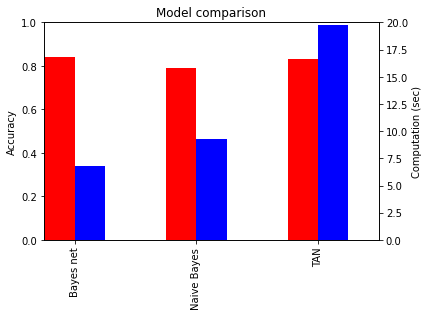

In [39]:
import matplotlib.pyplot as plt

results = {'Accuracy': [0.8412,0.7919,0.8329], 'Time': [6.76, 9.26,19.80]}
df = pd.DataFrame.from_dict(results)
df.index = ['Bayes net', "Naive Bayes", "TAN"]


fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.25

df.Accuracy.plot(kind='bar', color='red', ax=ax, width=width, position=1)
df.Time.plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('Accuracy')
ax2.set_ylabel('Computation (sec)')

ax.set_ylim([0,1])
ax2.set_ylim([0,20])

plt.title('Model comparison')
plt.show()

In [70]:
def assess_bayes_net2(G, prob_tables, data, outcomeSpace, class_var):
    
    var_blanket = markov_blanket(G,class_var)
    blanket_without_var = copy.deepcopy(var_blanket)
    var_blanket.append(class_var)
    var_remove = ['Metastasis', 'LymphNodes']
    var_list = [i for i in var_blanket if i not in var_remove] # now we get the variables that needs for inference class_var 
    
#     begin = time.time()
    p_table =  p_joint_blanket(var_list, outcomeSpace, prob_tables)
#     end = time.time()
#     print("The joining table costs {0:.2f} seconds".format(end-begin))
    
    
    
    q_var = class_var
    evidence_list = [var for var in var_list if var!=class_var]
    data_update = data[evidence_list]
    
    data_dict = data_update.to_dict(orient='records')
    outcomeSpace_copy = { var: outcomeSpace[var] for var in var_list}
    match_count = 0
    pred_list = []
    for i in range(len(data_dict)):
        q_table = query(p_table, outcomeSpace_copy, q_var, **data_dict[i])
        pred = max(q_table['table'],key=q_table['table'].get)[0]
        pred_list.append(pred)
    return (pred_list)

def assess_naive_bayes2(G_naive, naive_tables, data, outcomeSpace, class_var):
    naive_tables = additive_smoothing(naive_tables,data)
    
    node_list = list(outcomeSpace.keys())
    var_remove = ['Metastasis', 'LymphNodes']
    var_list = [i for i in node_list if i not in var_remove] #now we get all the variables 
    
    evidence_list = [var for var in var_list if var!=class_var]
    data_update = data[evidence_list]
    
    prior_prob = data[class_var].value_counts(normalize = True)   
    y_hat_series = data_update.apply(predict, y_space = outcomeSpace[class_var], table = naive_tables, prior = prior_prob, axis = 1)
    #correct_predict = np.sum(data[class_var] == y_hat_series)
    #acc = correct_predict/len( y_hat_series)
    
    return  y_hat_series

def assess_tan2(G_tan,tan_tables,test_data,outcomeSpace,class_var):
    tan_tables = update_tan_tables(tan_tables)
    prior = tan_tables[class_var]['table'][()]
    node_list = list(outcomeSpace.keys())
    var_remove = ['Metastasis', 'LymphNodes',class_var]
    var_list = [i for i in node_list if i not in var_remove] #now we get all the variables 
    data_update = data[var_list]
    data_dict = data_update.to_dict(orient='records')
    outcomeSpace_copy = { var: outcomeSpace[var] for var in var_list}
    match_count = 0
    pred_list = []
    for i in range(len(data_dict)):
        pred = tan_prediction(tan_tables,data_dict[i],outcomeSpace,class_var)
        pred_list.append(pred)
        if (pred == data.iloc[i][class_var]):
            match_count +=1
    return (pred_list)

In [52]:
yhat_bayes =  np.array(assess_bayes_net2(G, prob_tables, data, outcomeSpace, class_var))
data['yhat_bayes'] = yhat_bayes 



In [68]:
yhat_naive = assess_naive_bayes2(G_naive, naive_tables, data, outcomeSpace, 'BC')
data['yhat_naive'] = yhat_naive

In [71]:
G_tan = learn_tan_structure(data,outcomeSpace,class_var)
tan_tables = learn_bayes_net(G_tan,data, outcomeSpace)
yhat_tan = assess_tan2(G_tan,tan_tables,data,outcomeSpace,class_var)
data['yhat_tan'] = yhat_tan

In [66]:
pd.crosstab(data['BC'],data['yhat_bayes'], rownames = ['True'],colnames = ['Prediction'], margins = True, normalize = 'index')

Prediction,Insitu,Invasive,No
True,,,
Insitu,0.338971,0.421071,0.239958
Invasive,0.106924,0.789329,0.103748
No,0.014390,0.008361,0.977249
All,0.082300,0.251350,0.666350


In [69]:
pd.crosstab(data['BC'],data['yhat_naive'] , rownames = ['True'],colnames = ['Prediction'], margins = True, normalize = 'index')

Prediction,Insitu,Invasive,No
True,,,
Insitu,0.392882,0.396054,0.211064
Invasive,0.146729,0.723904,0.129367
No,0.083930,0.006190,0.909880
All,0.142600,0.231000,0.626400


In [75]:
pd.crosstab(data['BC'],data['yhat_tan'] , rownames = ['True'],colnames = ['Prediction'], margins = True, normalize = 'index')

Prediction,Insitu,Invasive,No
True,,,
Insitu,0.555673,0.299859,0.144468
Invasive,0.227610,0.698920,0.073470
No,0.072835,0.006914,0.920251
All,0.177900,0.211900,0.610200


In [40]:
## Develop your report in one or more cells here